In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
STL10_train_data = datasets.STL10(root='data', split='train', download=True, transform=transforms.ToTensor())
STL10_val_data = datasets.STL10(root='data', split='test', download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
AlexNet_train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(227),
                        transforms.RandomHorizontalFlip(),
])

AlexNet_val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(227),
])

# apply transforamtion
STL10_train_data.transform = AlexNet_train_transformation
STL10_val_data.transform = AlexNet_val_transformation

# create DataLoader
train_dl = DataLoader(STL10_train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(STL10_val_data, batch_size=32, shuffle=True)

In [4]:
# VGG16_train_transformation = transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Resize(224),
#                         transforms.RandomHorizontalFlip(),
# ])

# VGG16_val_transformation = transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Resize(224),
# ])

# # apply transforamtion
# STL10_train_data.transform = VGG16_train_transformation
# STL10_val_data.transform = VGG16_val_transformation

# # create DataLoader
# train_dl = DataLoader(STL10_train_data, batch_size=32, shuffle=True)
# val_dl = DataLoader(STL10_val_data, batch_size=32, shuffle=True)

In [5]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    print('labels.shape:', labels.shape)
    break

images.shape: torch.Size([32, 3, 227, 227])
labels.shape: torch.Size([32])


image indices: [ 235 3980  905 2763]


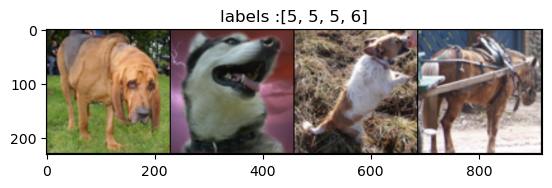

In [6]:
# display sample images 
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(STL10_train_data), grid_size)
print('image indices:',rnd_inds)

x_grid = [STL10_train_data[i][0] for i in rnd_inds]
y_grid = [STL10_train_data[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4, 0),
            nn.ReLU(),
            nn.MaxPool2d(3, 2), 
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(256, 384, 3, 1, 1), 
            nn.ReLU(), 
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

model = AlexNet().to(device)

In [8]:
# class VGG16(nn.Module):
#     def __init__(self):
#         super(VGG16, self).__init__()
#         self.features = nn.Sequential(
#             #########################################################################
#             # TODO:                                                                #
#             # Implement VGG16 architecture.                                        #
#             #########################################################################
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(# TODO, # TODO),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(# TODO, # TODO),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(# TODO, # TODO),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), 512 * 7 * 7)
#         x = self.classifier(x)
#         return x

# model = VGG16().to(device)

In [9]:
# configs
epochs = 10
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# train
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    one_epoch_loss = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        one_epoch_loss += loss.item()
    return one_epoch_loss / len(data_loader)

def eval_one_epoch(model, data_loader, device):
    model.eval()
    one_epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            loss = criterion(pred, y)

            one_epoch_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return one_epoch_loss / len(data_loader), correct / len(data_loader.dataset)

def train():
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, optimizer, train_dl, device)
        print(f'Epoch {epoch+1} / {epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        eval_loss, correct = eval_one_epoch(model, val_dl, device)
        print(f'Eval Loss: {eval_loss:.4f}, Eval Acc: {100 * correct:.4f}%')
train()


Epoch 1 / 10
Train Loss: 3.5653
Eval Loss: 2.3126, Eval Acc: 10.0000%
Epoch 2 / 10
Train Loss: 2.0722
Eval Loss: 1.8984, Eval Acc: 21.7000%
Epoch 3 / 10
Train Loss: 1.8680
Eval Loss: 1.7527, Eval Acc: 26.8125%
Epoch 4 / 10
Train Loss: 1.7077
Eval Loss: 1.6796, Eval Acc: 32.6500%
Epoch 5 / 10
Train Loss: 1.6474
Eval Loss: 1.6000, Eval Acc: 35.7000%
Epoch 6 / 10
Train Loss: 1.5795
Eval Loss: 1.5527, Eval Acc: 38.0875%
Epoch 7 / 10
Train Loss: 1.5241
Eval Loss: 1.4916, Eval Acc: 40.5750%
Epoch 8 / 10
Train Loss: 1.4788
Eval Loss: 1.4107, Eval Acc: 46.3750%
Epoch 9 / 10
Train Loss: 1.4452
Eval Loss: 1.3987, Eval Acc: 46.1625%
Epoch 10 / 10
Train Loss: 1.3626
Eval Loss: 1.4025, Eval Acc: 45.4000%
